## **Resumen Ejecutivo de la Estructura del Código**  

Este código implementa un modelo de predicción de series temporales utilizando **XGBoost** dentro de un enfoque de **modelado recursivo** con `ForecasterRecursive` usando la librería `skforecast`. Se estructura siguiendo una metodología estándar de modelado de series temporales, combinando técnicas de **optimización de hiperparámetros**, **validación cruzada**, **evaluación de errores** y **coverage** para garantizar la robustez del modelo.  

### **1. Configuración Inicial**  



In [23]:
# Manipulacion de datos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

# Liberías de series de tiempo
from skforecast.recursive import ForecasterRecursive
from skforecast.model_selection import TimeSeriesFold, bayesian_search_forecaster, backtesting_forecaster
from skforecast.plot import plot_residuals
from skforecast.preprocessing import RollingFeatures
from skforecast.feature_selection import select_features

# Sklearn y XGBoost para modelado
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFECV
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline

# Librerías de Feature engineering 
from feature_engine.creation import CyclicalFeatures
from feature_engine.datetime import DatetimeFeatures
from feature_engine.timeseries.forecasting import WindowFeatures, LagFeatures

# Librerías para importar módulos de otros directorios
import os
import sys
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)
from utils.eda import TimeSeriesAnalyzer
from utils.preprocessing import DataProcessor

# Suppress warnings
warnings.filterwarnings('ignore')

#Parametrós de gráficos
plt.style.use('seaborn-v0_8-darkgrid')
warnings.filterwarnings('once')
plt.rcParams['axes.grid'] = False

### **2. Preprocesamiento**  

In [24]:
#Instanciamos a la clase que procesa los datos
directorio = '../'
processor = DataProcessor(directorio+'raw/Base de operaciones.csv', directorio+'raw/Mesas de dinero y casas.xlsx')
# Ejecutar el procesamiento completo
data1, data_train, data_val, data_test = processor.process_data()

Datos procesados exitosamente.



Resumen de Datos:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27744 entries, 2020-08-01 00:00:00 to 2023-09-30 23:00:00
Freq: h
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   col1    27744 non-null  float64
 1   col2    27744 non-null  float64
 2   target  27744 non-null  float64
 3   col3    27744 non-null  float64
 4   col4    27744 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 2.3 MB
None

Graficando la serie temporal...


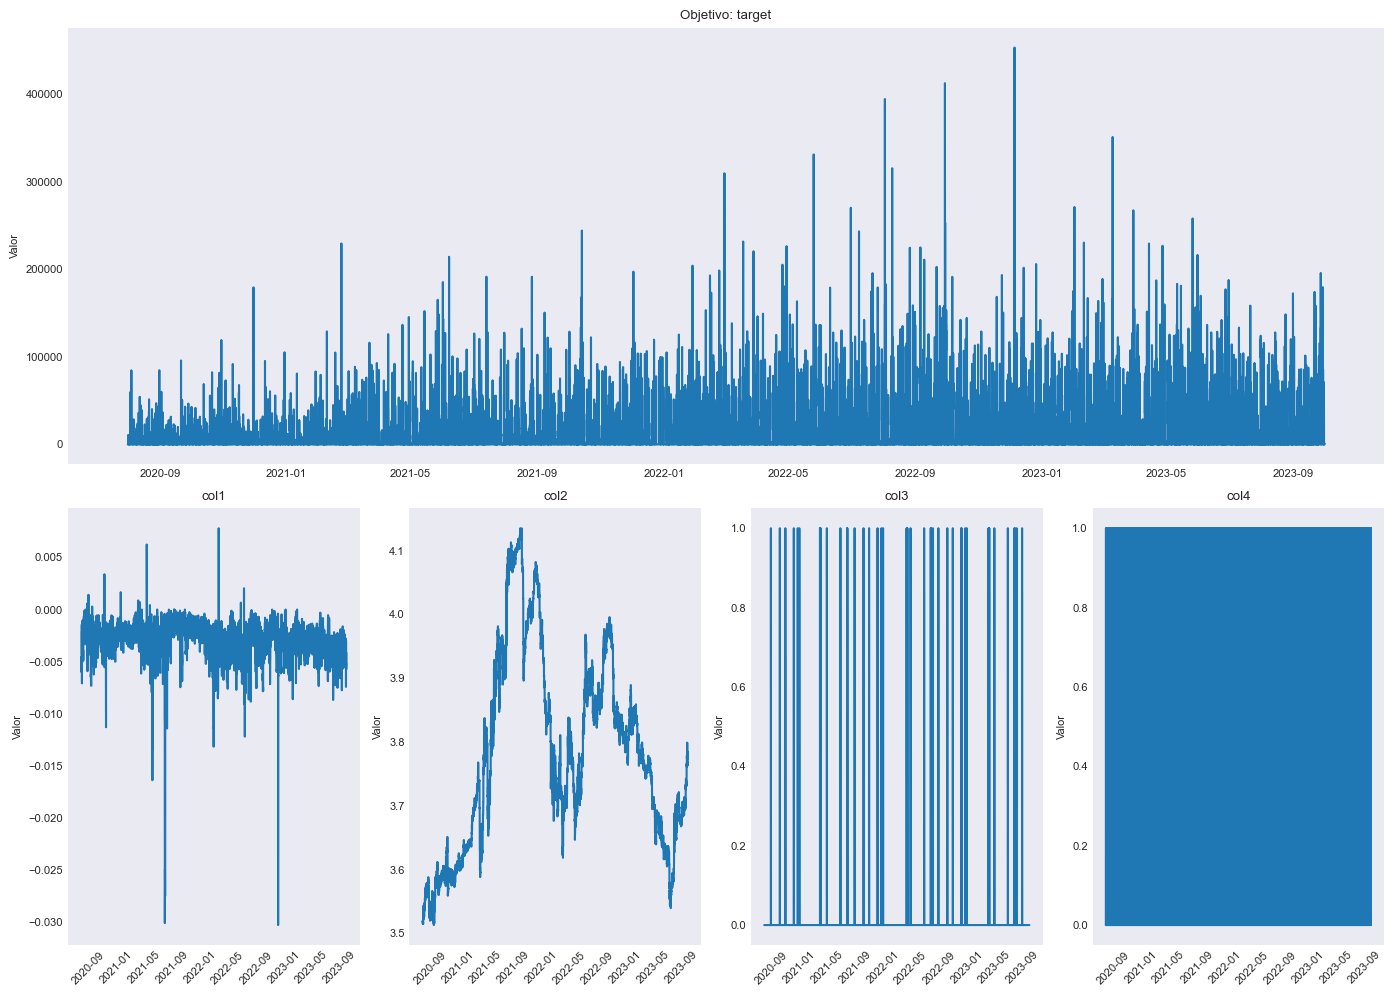


Descomponiendo la serie temporal...


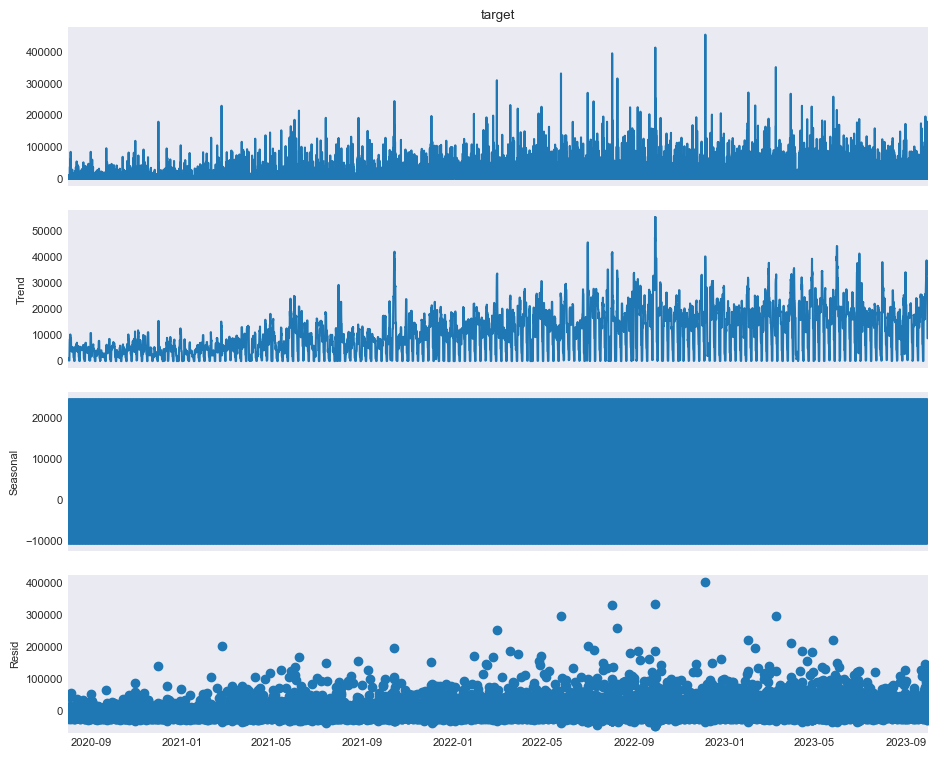


Graficando la función de autocorrelación y autocorrelación parcial...


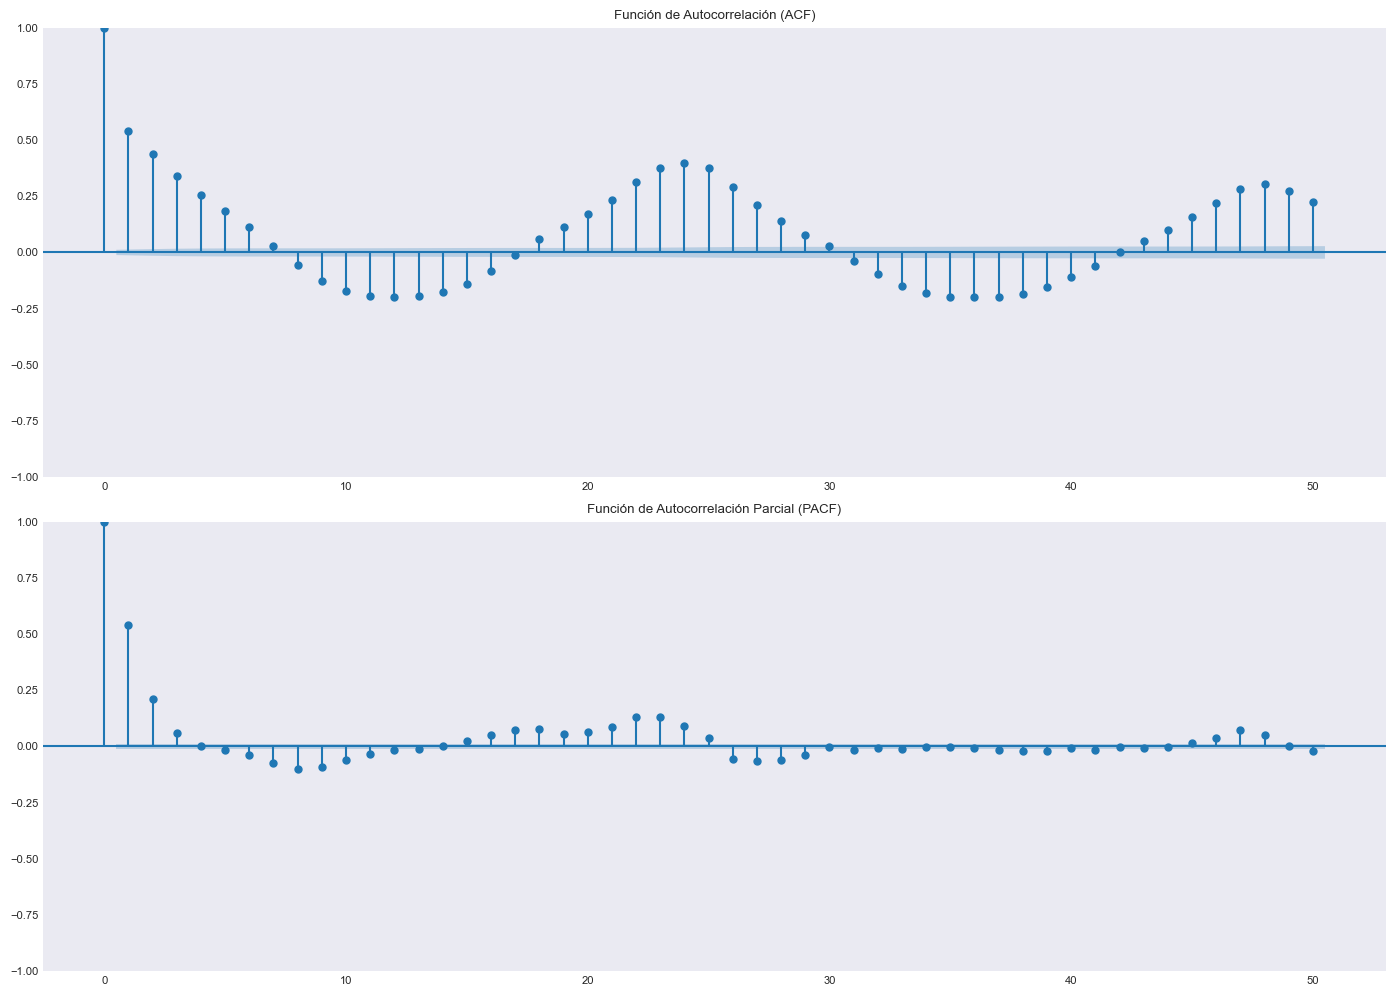


Graficando el mapa de calor de correlación...


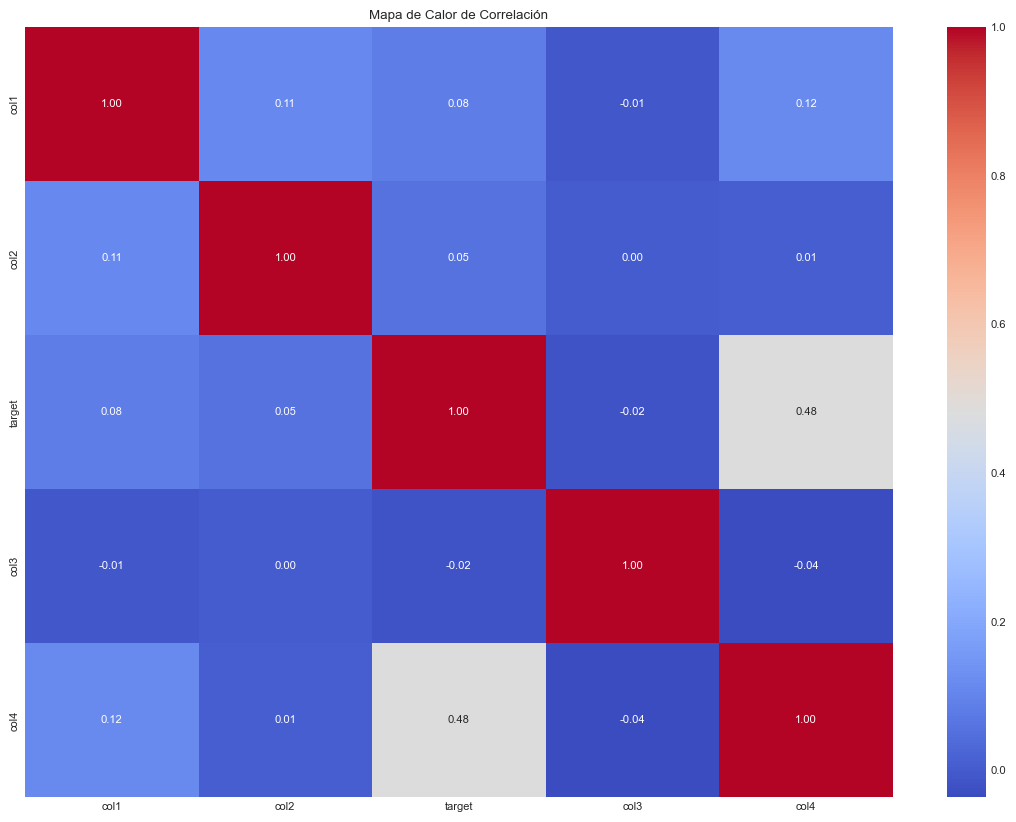

In [25]:
# Aplicamos un EDA a la serie de tiempo de la variable objetivo 'target' para entender mejor su comportamiento.
analyzer = TimeSeriesAnalyzer(data1, 'target')
analyzer.display_summary()
analyzer.plot_time_series()
analyzer.decompose_seasonality()
analyzer.plot_autocorrelation()
analyzer.plot_correlation_heatmap()

**Notas**:
- Existe una tendencia creciente aditiva y un fuerte componente estacional diario que se refleja en los graficos de descomposición y persiste en los diagramas de ACF y PACF. 
- Además se observa que únicamente una correlación significativa entre el target y col4 que es una feature con un comportamiento uniforme.  

In [26]:
# Parámetros auxiliares
end_validation = data_val.index.max()
end_test = data_test.index.max()
exog_cols = data1.drop(columns=['target']).columns

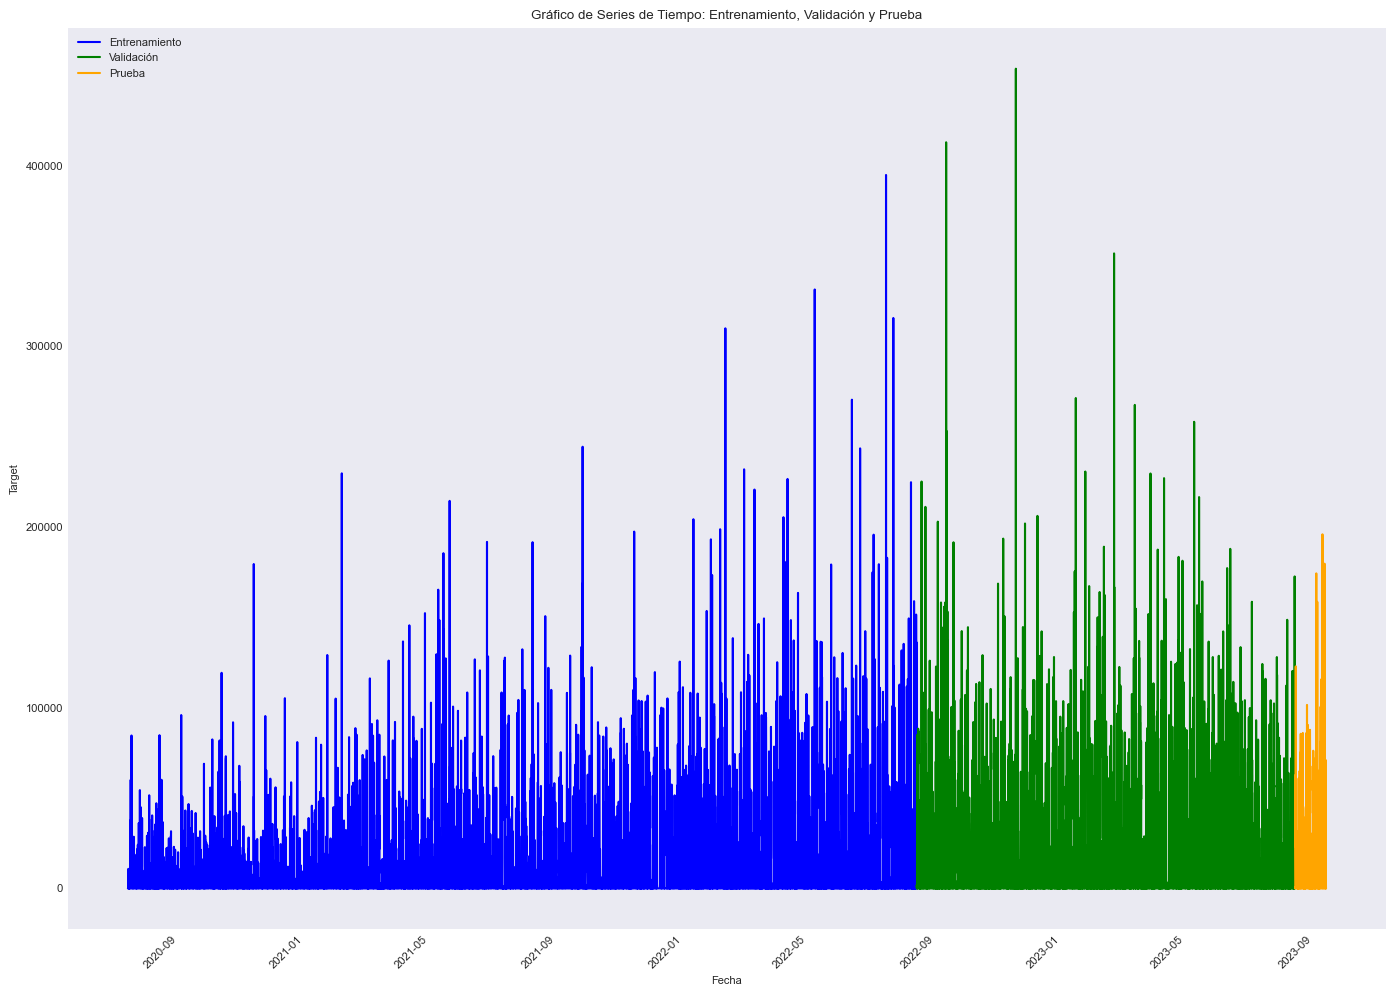

In [27]:
# Graficamos la serie de tiempo dividida en entrenamiento, validación y prueba
plt.figure(figsize=(14, 10))
plt.plot(data_train.index, data_train['target'], label='Entrenamiento', color='blue')
plt.plot(data_val.index, data_val['target'], label='Validación', color='green')
plt.plot(data_test.index, data_test['target'], label='Prueba', color='orange')
plt.title('Gráfico de Series de Tiempo: Entrenamiento, Validación y Prueba')
plt.xlabel('Fecha')
plt.ylabel('Target')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [28]:
# Creamos variables rezagadas y window features
lag_transformer = LagFeatures(
                    variables = ["col1", "col2","col3"],
                    periods   = [1, 2, 3],
                  )

wf_transformer = WindowFeatures(
                    variables      = ["col1", "col2","target"],
                    window         = ["24h"],
                    functions      = ["mean"],
                    freq           = "h",
                    missing_values = "ignore",
                    drop_na        = False,
                )
exog_transformer = make_pipeline(
                        wf_transformer,
                        lag_transformer
                   )
exog_transformer

Pipeline(steps=[('windowfeatures',
                 WindowFeatures(freq='h', functions=['mean'],
                                missing_values='ignore',
                                variables=['col1', 'col2', 'target'],
                                window=['24h'])),
                ('lagfeatures',
                 LagFeatures(periods=[1, 2, 3],
                             variables=['col1', 'col2', 'col3']))])

In [29]:
data1=exog_transformer.fit_transform(data1).fillna(0)

### **3. Feature engineering** 

In [30]:
#Creamos variables cíclicas y de vista
window_features = RollingFeatures(
                      stats        = ['mean', 'mean', 'sum'],
                      window_sizes = [24, 48, 24]
                  )
features_to_extract = [
    'month',
    'week',
    'day_of_week',
    'hour'
]
calendar_transformer = DatetimeFeatures(
    variables='index',
    features_to_extract=features_to_extract,
    drop_original=True,
)
calendar_features = calendar_transformer.fit_transform(data1)[features_to_extract]

# Aplicamos encoding a las variabels cíclicas
features_to_encode = [
    "month",
    "week",
    "day_of_week",
    "hour"]
max_values = {
    "month": 12,
    "week": 52,
    "day_of_week": 6,
    "hour": 23}
cyclical_encoder = CyclicalFeatures(
    variables     = features_to_encode,
    max_values    = max_values,
    drop_original = False
)
exogenous_features = cyclical_encoder.fit_transform(calendar_features)

In [31]:
# Combinamos posibles interacciones combinadad de las variabels
transformer_poly = PolynomialFeatures(
                        degree           = 2,
                        interaction_only = True,
                        include_bias     = False
                    ).set_output(transform="pandas")
poly_cols = [
    'month_sin', 
    'month_cos',
    'week_sin',
    'week_cos',
    'day_of_week_sin',
    'day_of_week_cos',
    'hour_sin',
    'hour_cos',]
# Aplicamos encoding a las variabels cíclicas
poly_features = transformer_poly.fit_transform(exogenous_features[poly_cols])
poly_features = poly_features.drop(columns=poly_cols)
poly_features.columns = [f"poly_{col}" for col in poly_features.columns]
poly_features.columns = poly_features.columns.str.replace(" ", "__")
assert all(poly_features.index == exogenous_features.index)
exogenous_features = pd.concat([exogenous_features, poly_features], axis=1)


In [32]:
#Incorporamos y actualizamos las variables exogenas
data1 = pd.concat([data1, exogenous_features], axis=1)
exog_cols = data1.drop(columns=['target']).columns
data1.to_csv('../processed/data1_processed.csv')

### **4. Generamos el forecaster para XGB**  


In [33]:
# Configuración inicial
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")

# Creamos el forecaster con XGBoost
forecaster = ForecasterRecursive(
    regressor = XGBRegressor(tree_method='auto', 
                            random_state=123),
                            lags = 48,
    window_features=window_features  
)

In [34]:
# Backtesting en datos de test con variables exógenas
cv = TimeSeriesFold(
    steps=48,
    initial_train_size=len(data1.loc[:end_validation]),
    refit=False
)
metrica, predicciones_bkt = backtesting_forecaster(
                        forecaster      =   forecaster,
                        y               =   data1['target'],
                        exog            =   data1[exog_cols],
                        cv              =   cv,
                        metric          =   'mean_absolute_error',
                        n_jobs          =   'auto',
                        verbose         =   False,
                        show_progress   =   True
                    )
metrica

100%|██████████| 15/15 [00:00<00:00, 25.60it/s]


,mean_absolute_error
0,10548.512153



### **5. Optimización de Hiperparámetros**  
Se utiliza un **enfoque de búsqueda bayesiana** (`bayesian_search_forecaster`) para encontrar la mejor combinación de hiperparámetros del modelo. 
En skforecast, la optimización bayesiana con `Optuna`. El objetivo de la optimización es minimizar la métrica generada por el backtesting. En este caso, queremos minimizar el MAE. 

In [35]:
# Definir posibles lags para la optimización
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 167, 168, 169]]

def search_space(trial):
    return {
        'n_estimators': trial.suggest_int('n_estimators', 400, 1500, step=100),
        'max_depth': trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1, step=0.01),
        'subsample': trial.suggest_float('subsample', 0.1, 1, step=0.01),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1, step=0.01),
        'gamma': trial.suggest_float('gamma', 0, 1, step=0.1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1, step=0.1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1, step=0.1),
        'lags': trial.suggest_categorical('lags', lags_grid)
    }
# Validación cruzada con series de tiempo
cv = TimeSeriesFold(
        initial_train_size=len(data_train),
        steps=48,
        refit=False
    )
# Búsqueda de hiperparámetros
results_search, frozen_trial = bayesian_search_forecaster(
                                            forecaster      =forecaster,
                                            y               =data1.loc[:end_validation, 'target'],
                                            exog            =data1.loc[:end_validation, exog_cols],
                                            search_space    =search_space,
                                            cv              =cv,
                                            metric          ='mean_absolute_error',
                                            n_trials        =20,
                                            return_best     =True,
                                            n_jobs          ='auto',
                                            verbose         =False,
                                            show_progress   =True
                                        )
results_search.head()

Best trial: 13. Best value: 9531.39: 100%|██████████| 20/20 [05:07<00:00, 15.38s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3  23  24  25 167 168 169] 
  Parameters: {'n_estimators': 1300, 'max_depth': 4, 'learning_rate': 0.01, 'subsample': 0.5700000000000001, 'colsample_bytree': 0.77, 'gamma': 0.8, 'reg_alpha': 1.0, 'reg_lambda': 0.8}
  Backtesting metric: 9531.39434372926


,lags,params,mean_absolute_error,n_estimators,max_depth,learning_rate,subsample,colsample_bytree,gamma,reg_alpha,reg_lambda
0,"[1, 2, 3, 23, 24, 25, 167, 168, 169]","{'n_estimators': 1300, 'max_depth': 4, 'learni...",9531.394344,1300.0,4.0,0.01,0.57,0.77,0.8,1.0,0.8
1,"[1, 2, 3, 23, 24, 25, 167, 168, 169]","{'n_estimators': 1100, 'max_depth': 4, 'learni...",9652.016140,1100.0,4.0,0.01,0.53,0.95,0.7,0.7,0.6
2,"[1, 2, 3, 23, 24, 25, 167, 168, 169]","{'n_estimators': 1200, 'max_depth': 5, 'learni...",11584.223222,1200.0,5.0,0.23,0.60,0.75,0.4,1.0,0.7
3,"[1, 2, 3, 23, 24, 25, 167, 168, 169]","{'n_estimators': 1400, 'max_depth': 4, 'learni...",12926.318826,1400.0,4.0,0.15,0.47,0.14,1.0,1.0,0.8
4,"[1, 2, 3, 23, 24, 25, 167, 168, 169]","{'n_estimators': 1500, 'max_depth': 5, 'learni...",13615.540247,1500.0,5.0,0.19,0.44,0.10,1.0,0.5,0.7


In [36]:
# Mejores hiperparámetros leugo del proceso de optimización bayesiana
best_params = results_search['params'].iat[0]
best_params = best_params | {'random_state': 123, 'verbose': -1}

### **6. Cross Validation para Series Temporales**  
Usamos **validación cruzada con `TimeSeriesFold`**, que respeta la secuencialidad de los datos. Evaluamos el modelo con **backtesting**, para medir el desempeño en diferentes puntos del tiempo y simular un uso en producción.  


In [37]:
# Backtesting en datos de test con variables exógenas
cv = TimeSeriesFold(
    steps=48,
    initial_train_size=len(data1.loc[:end_validation]),
    refit=False
)
metrica, predictions_bkt = backtesting_forecaster(
                        forecaster              =   forecaster,
                        y                       =   data1['target'],
                        exog                    =   data1[exog_cols],
                        cv                      =   cv,
                        metric                  =   'mean_absolute_error',

                        use_in_sample_residuals =   True,  
                        use_binned_residuals    =   True,   
                        n_jobs                  =   'auto',
                        verbose                 =   False,
                        show_progress           =    True
                        )
metrica

100%|██████████| 15/15 [00:00<00:00, 5887.02it/s]


,mean_absolute_error
0,8340.746442


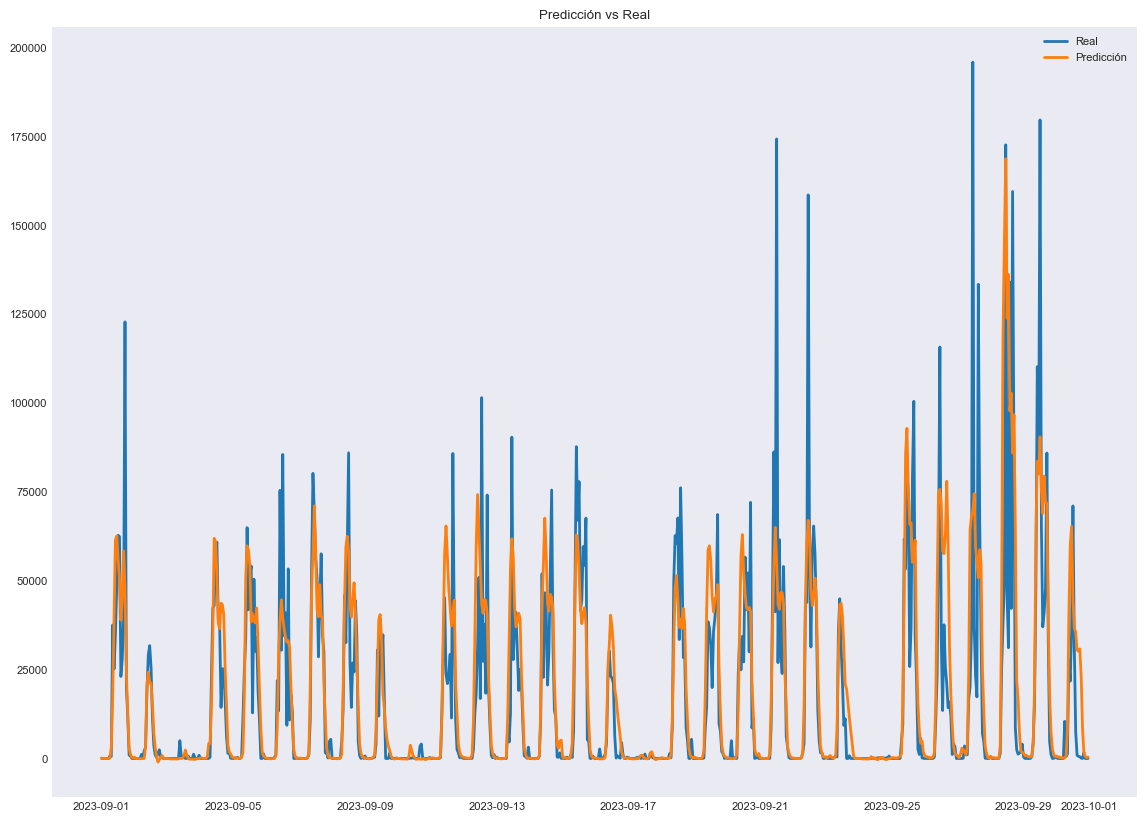

In [38]:
# Visualización de resultados
plt.figure(figsize=(14, 10))
plt.plot(data1.loc[predictions_bkt.index, 'target'], linewidth=2, label='Real')
plt.plot(predictions_bkt, linewidth=2, label='Predicción')
plt.title('Predicción vs Real')
plt.legend()
plt.savefig('../img/prediccion_vs_real.png')
plt.show()

### **7. Análisis de Residuos**  
Se analizan los errores del modelo comparando predicciones con valores reales.  
- Se grafican residuos para verificar su distribución y detectar posibles **patrones no capturados** (violaciones a la hipótesis de ruido blanco).  
- Se almacenan los residuos en el modelo (`set_out_sample_residuals()`) para mejorar la calibración de los intervalos de predicción.  

Este análisis es clave en series temporales, donde errores autocorrelacionados pueden indicar que el modelo no está capturando correctamente la dinámica del tiempo.  


In [39]:
# Backtesting con datos de validación para obtener residuos
cv = TimeSeriesFold(
                    steps=48,
                    initial_train_size=len(data1.loc[:end_validation]),
                    refit=False
)
_, predictions_val = backtesting_forecaster(
                    forecaster=forecaster,
                    y                       =   data1['target'],
                    exog                    =   data1[exog_cols],
                    cv                      =   cv,
                    metric                  =   'mean_absolute_error',
                    interval                =   [5, 95],
                    n_boot                  =   150,
                    use_in_sample_residuals =   True,  
                    use_binned_residuals    =   True,   
                    n_jobs                  =   'auto',
                    verbose                 =   False,
                    show_progress           =    True)

100%|██████████| 15/15 [00:00<00:00, 27130.04it/s]


negative    456
positive    264
Name: count, dtype: int64


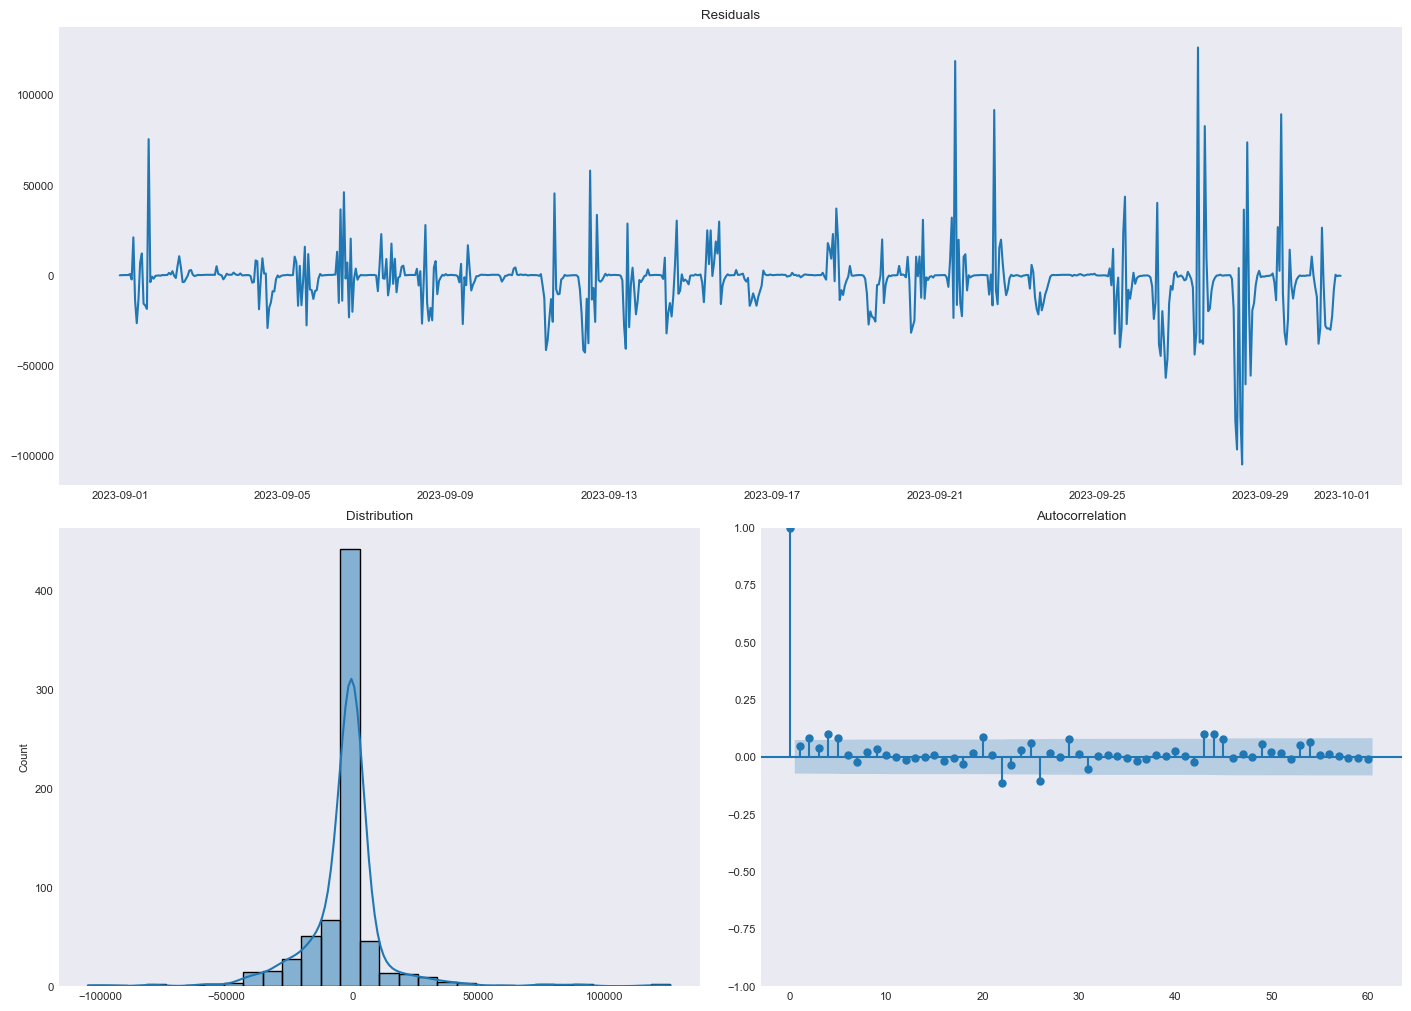

In [40]:
# Cálculo de residuos out-sample
residuals = data1.loc[predictions_val.index, 'target'] - predictions_val['pred']
print(pd.Series(np.where(residuals < 0, 'negative', 'positive')).value_counts())
plt.rcParams.update({'font.size': 8})
_ = plot_residuals(
    y_true=data1.loc[predictions_val.index, 'target'],
    y_pred=predictions_val['pred'],
    figsize=(14, 10)
)
plt.savefig('../img/residuos.png')
plt.show()

In [41]:
# Almacenamos los residuos en el forecaster
forecaster.set_out_sample_residuals(
    y_true=data1.loc[predictions_val.index, 'target'],
    y_pred=predictions_val['pred']
)

In [42]:
# Backtesting con intervalos de predicción usando out-sample residuals
cv = TimeSeriesFold(
        steps              = 48,
        initial_train_size = len(data1.loc[:end_validation]),
        refit              = False,
    )
metric, predictions_fin = backtesting_forecaster(
                    forecaster              =   forecaster,
                    y                       =   data1.loc[:end_test, 'target'],
                    exog                    =   data1.loc[:end_test, exog_cols],
                    cv                      =   cv,
                    metric                  =   'mean_absolute_error',
                    interval                =   [5, 95],
                    n_boot                  =   150,
                    use_in_sample_residuals =   True,  
                    use_binned_residuals    =   True,   
                    n_jobs                  =   'auto',
                    verbose                 =   False,
                    show_progress           =    True
)
print(f"MAE: {metric}")

100%|██████████| 15/15 [00:00<00:00, 5016.31it/s]


MAE:    mean_absolute_error
0          8340.746442


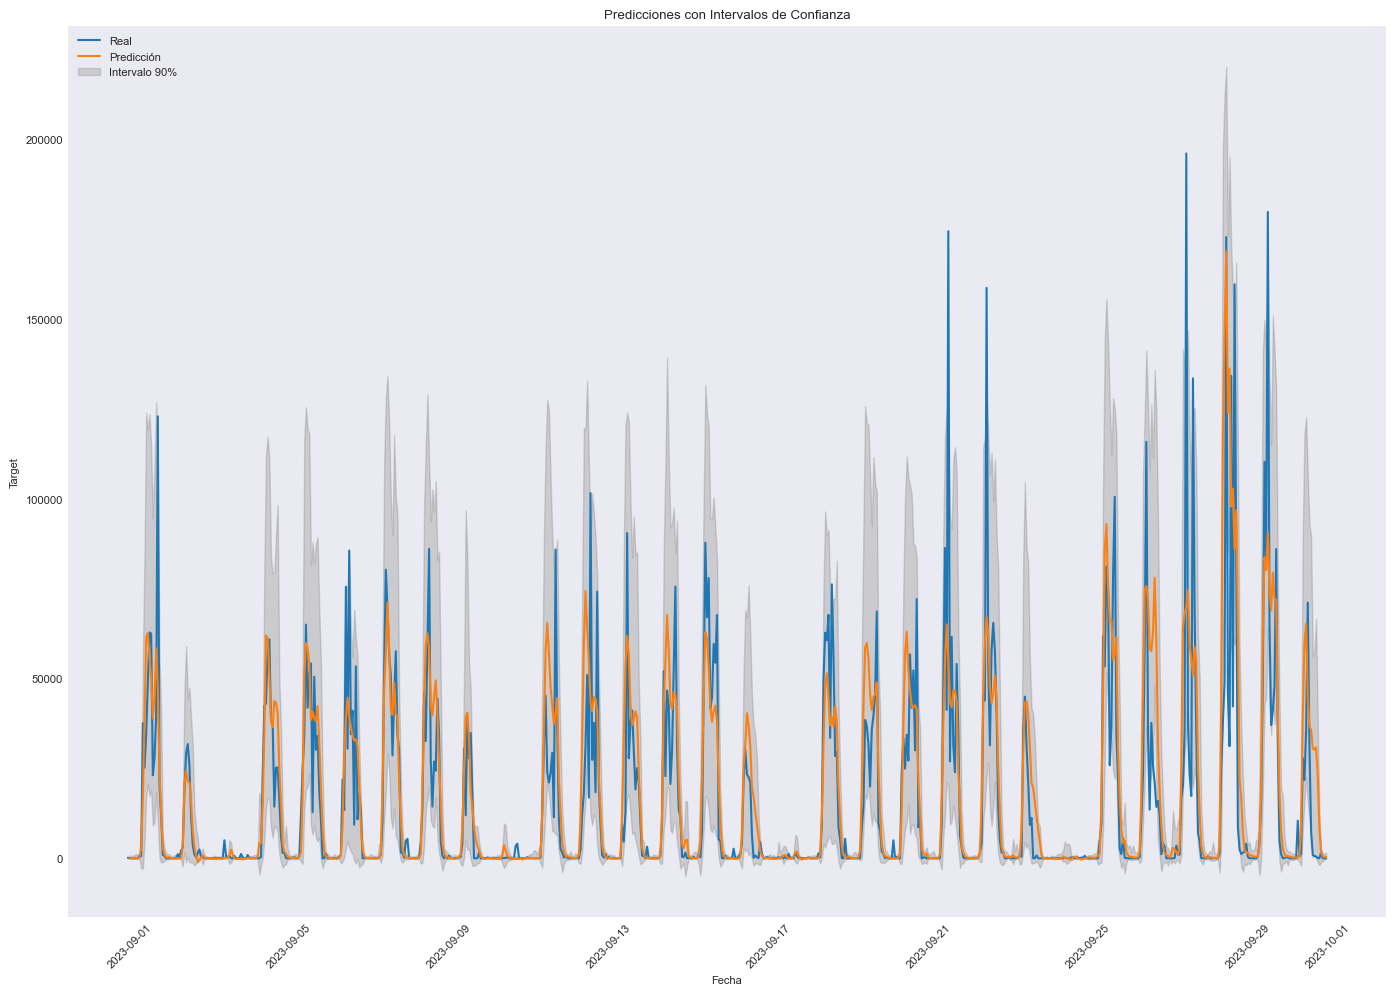

In [43]:
# Gráfico de predicciones con intervalos de confianza
plt.figure(figsize=(14, 10))
plt.plot(data1.loc[data_val.index.max():end_test, 'target'], label='Real')
plt.plot(predictions_fin.loc[data_val.index.max():end_test, 'pred'], label='Predicción')
intervalo = predictions_fin.loc[data_val.index.max():end_test]
plt.fill_between(intervalo.index, 
                 intervalo['lower_bound'], 
                 intervalo['upper_bound'], 
                 color='gray', alpha=0.3, label='Intervalo 90%')

plt.title('Predicciones con Intervalos de Confianza')
plt.xlabel('Fecha')
plt.ylabel('Target')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../img/predicciones_intervalos.png')
plt.show()


Vamos a evaluar intervalos de predicción para validar si hemos encontrado un balance entre precisión y confiabilidad.

In [44]:
#Cobertura del intervalo de predicción
coverage = np.mean(
    np.logical_and(
        data1.loc[data_test.index.min():end_test, 'target'] >= predictions_fin["lower_bound"],
        data1.loc[data_test.index.min():end_test, 'target'] <= predictions_fin["upper_bound"]
    )
)
area = (predictions_fin['upper_bound'] - predictions_fin['lower_bound']).sum()
print(f"Predicted interval coverage: {round(100 * coverage, 2)} %")

Predicted interval coverage: 92.36 %
